# Global Sensitivity Analysis
https://docs.juliadiffeq.org/latest/analysis/global_sensitivity/#Lotka-Volterra-Global-Sensitivities-1
Global Sensitivity Analysis (GSA) methods are used to quantify the uncertainty in output of a model w.r.t. the parameters, their individual contributions, or the contribution of their interactions. The GSA interface allows for utilizing batched functions for parallel computation of GSA quantities.

## Lotka-Volterra Global Sensitivities

In [14]:
using DiffEqSensitivity, Statistics, OrdinaryDiffEq
using QuasiMonteCarlo
using Plots
gr()

┌ Info: Precompiling QuasiMonteCarlo [8a4e6c94-4038-4cdc-81c3-7e6ffdb2a71b]
└ @ Base loading.jl:1273


Plots.GRBackend()

In [15]:
function f(du,u,p,t)
  du[1] = p[1]*u[1] - p[2]*u[1]*u[2] #prey
  du[2] = -p[3]*u[2] + p[4]*u[1]*u[2] #predator
end
u0 = [1.0;1.0]
tspan = (0.0,10.0)
p = [1.5,1.0,3.0,1.0]
prob = ODEProblem(f,u0,tspan,p) 
t = collect(range(0, stop=10, length=200))

200-element Array{Float64,1}:
  0.0                
  0.05025125628140704
  0.10050251256281408
  0.1507537688442211 
  0.20100502512562815
  0.25125628140703515
  0.3015075376884422 
  0.35175879396984927
  0.4020100502512563 
  0.45226130653266333
  0.5025125628140703 
  0.5527638190954773 
  0.6030150753768844 
  ⋮                  
  9.447236180904522  
  9.49748743718593   
  9.547738693467336  
  9.597989949748744  
  9.64824120603015   
  9.698492462311558  
  9.748743718592964  
  9.798994974874372  
  9.849246231155778  
  9.899497487437186  
  9.949748743718592  
 10.0                

Now let's create a function that takes in a parameter set and calculates the maximum of the predator population and the average of the prey population for those parameter values. To do this, we will make use of the remake function which creates a new ODEProblem, and use the p keyword argument to set the new parameters:

In [16]:
f1 = function (p)
  prob1 = remake(prob;p=p)
  sol = solve(prob1,Tsit5();saveat=t)
  [mean(sol[1,:]), maximum(sol[2,:])]
end

#9 (generic function with 1 method)

Now let's perform a Morris global sensitivity analysis on this model. We specify that the parameter range is [1,5] for each of the parameters, and thus call:

In [17]:
m = gsa(f1,Morris(total_num_trajectory=1000,num_trajectory=150),[[1,5],[1,5],[1,5],[1,5]])

DiffEqSensitivity.MorrisResult{Array{Float64,2},Array{Any,1}}([0.13715431760284094 0.020593334342320246 0.3780004025887243 0.4670089646927272; 0.5748965694017728 1.0774999529619358 0.3422115338174255 0.3497796556692599], [0.1060338235313735 0.0006166982793181278 0.03495733238740061 0.34353867758732876; 0.38677498653688674 3.1065913355615553 0.07202169738243555 0.14260060174928924], Any[Array{Float64,1}[[0.05962213466053385, 0.10689969224605936], [0.07198766904353919, 0.09675220683458478], [0.07063548954666236, 0.11396264394402715], [0.07450529474193811, 0.49457917141434043], [0.039112207787082076, 0.4239951352493139], [0.039112207787082076, 0.4239951352493139], [0.02264957936644762, 0.7558901101086872], [0.020753847813478003, 0.7759428123086604], [0.018296746977946386, 0.7638654413695573], [0.1873740408074839, 0.13628181161260156]  …  [0.0018195460625767706, 0.2877471511431214], [0.0018195460625767706, 0.2877471511431214], [0.07170970421957905, 0.3044248373173042], [0.07170970421957905

Let's get the means and variances from the MorrisResult struct.

In [18]:
m.means

2×4 Array{Float64,2}:
 0.137154  0.0205933  0.378     0.467009
 0.574897  1.0775     0.342212  0.34978 

In [19]:
m.variances

2×4 Array{Float64,2}:
 0.106034  0.000616698  0.0349573  0.343539
 0.386775  3.10659      0.0720217  0.142601

Let's plot the result

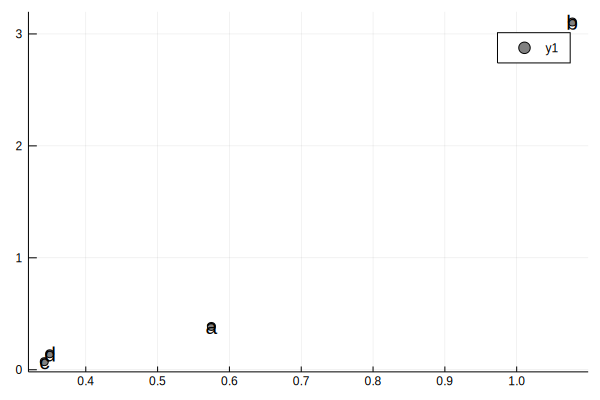

In [20]:
scatter(m.means[1,:], m.variances[1,:],series_annotations=[:a,:b,:c,:d],color=:gray)
scatter(m.means[2,:], m.variances[2,:],series_annotations=[:a,:b,:c,:d],color=:gray)

For the Sobol method we can similarly do:

In [21]:
m = gsa(f1,Sobol(),[[1,5],[1,5],[1,5],[1,5]])

MethodError: MethodError: no method matching gsa(::var"#9#10", ::Sobol, ::Array{Array{Int64,1},1})
Closest candidates are:
  gsa(::Any, !Matched::Morris, ::AbstractArray{T,1} where T; batch) at /home/seneryilmaz/.julia/packages/DiffEqSensitivity/4MT0T/src/morris_sensitivity.jl:68
  gsa(::Any, ::Sobol, !Matched::AbstractArray{T,2} where T, !Matched::AbstractArray{T,2} where T; batch, Ei_estimator) at /home/seneryilmaz/.julia/packages/DiffEqSensitivity/4MT0T/src/sobol_sensitivity.jl:27

## Design Matrices
For the Sobol Method, we can have more control over the sampled points by generating design matrices. Doing it in this manner lets us directly specify a quasi-Monte Carlo sampling method for the parameter space. Here we use QuasiMonteCarlo.jl to generate the design matrices as follows:

In [13]:
N = 10000
lb = [1.0, 1.0, 1.0, 1.0]
ub = [5.0, 5.0, 5.0, 5.0]
sampler = SobolSample()
A,B = QuasiMonteCarlo.generate_design_matrices(N,lb,ub,sampler)

UndefVarError: UndefVarError: SobolSample not defined